In [1]:
# Import llibreries

import json
import os
import sys
import time
import datetime
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Directori de treball

# Ruta on esta el script actual
# __path__ = os.path.dirname(os.path.realpath(__file__)) # Si es fitxer .py
__path__ = os.getcwd() # Si es fitxer .ipynb

carpeta_dades = 'Dades_T_estacions_xema_Z1'
fitxer_dades = 'SCM_T_Z1.json'

path_dades = os.path.join(os.getcwd(), carpeta_dades, fitxer_dades)


    # Obrir un arxiu json per veure com esta estructurat i com organitzar les dades
with open(path_dades, 'r') as f:
    data = json.load(f)

    # Accedemos a las lecturas (temperaturas) del JSON
lecturas = data[0]['variables'][0]['lectures']

#     # Convertimos las lecturas a un DataFrame con solo las columnas necesarias
df = pd.DataFrame(lecturas)[['data', 'valor']]


# Convertimos la columna 'data' a tipo datetime para análisis posterior
df['data'] = pd.to_datetime(df['data'])

df.head()


,data,valor
0,1998-01-01 00:00:00+00:00,-4.6
1,1998-01-01 01:00:00+00:00,-5.1
2,1998-01-01 02:00:00+00:00,-5.3
3,1998-01-01 03:00:00+00:00,-5.5
4,1998-01-01 04:00:00+00:00,-5.8


In [3]:
# Agafar només les dades corresponents als hiverns i posar-les en un nou dataframe
# Les dates dels hiverns seran del 1 de desembre al 31 de març
df_hiverns = df[(df['data'].dt.month >= 11) | (df['data'].dt.month <= 2)]

df_hiverns.head()

,data,valor
0,1998-01-01 00:00:00+00:00,-4.6
1,1998-01-01 01:00:00+00:00,-5.1
2,1998-01-01 02:00:00+00:00,-5.3
3,1998-01-01 03:00:00+00:00,-5.5
4,1998-01-01 04:00:00+00:00,-5.8


In [6]:
# Establir llindars de Temperatura per a cada situació discreta
# 1. Temperatura mes baixa de 1 grau dona neu
# 2. Temperatura entre 1 i 2 graus dona aiguaneu
# 3. Temperatura superior a 2 graus dona pluja

# Afegim una columna amb la categoria de precipitació N,A,P


df_hiverns.loc[:, 'precipitacio'] = pd.cut(df_hiverns['valor'], bins=[-np.inf, 1, 2, np.inf], labels=['N', 'A', 'P'])

df_hiverns.head()

,data,valor,precipitacio
0,1998-01-01 00:00:00+00:00,-4.6,N
1,1998-01-01 01:00:00+00:00,-5.1,N
2,1998-01-01 02:00:00+00:00,-5.3,N
3,1998-01-01 03:00:00+00:00,-5.5,N
4,1998-01-01 04:00:00+00:00,-5.8,N


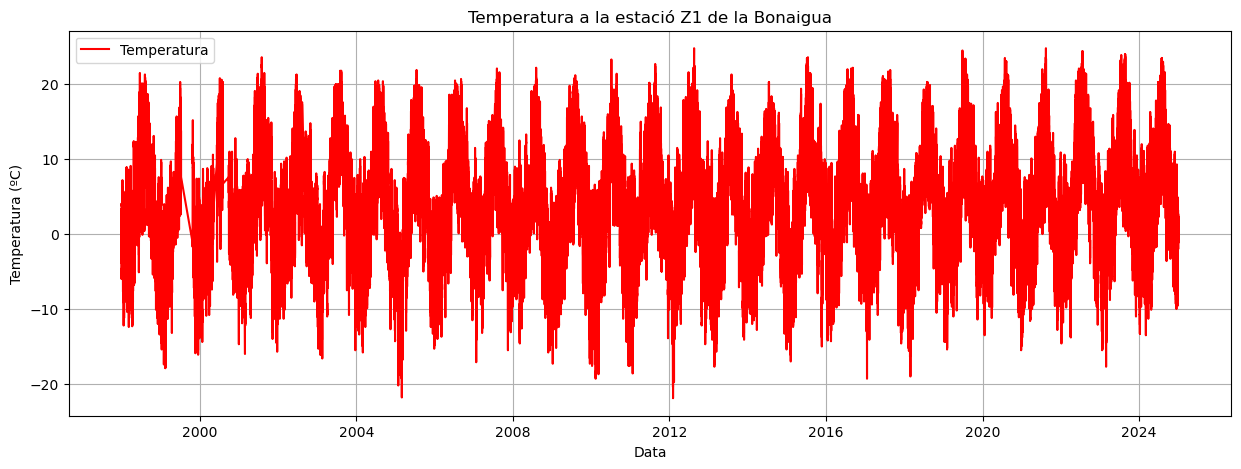

In [7]:
# Graficar la temperatura de les dades de df

plt.figure(figsize=(15, 5))
plt.plot(df['data'], df['valor'], label='Temperatura', color='red')
plt.title('Temperatura a la estació Z1 de la Bonaigua')
plt.xlabel('Data')
plt.ylabel('Temperatura (ºC)')
plt.legend()
plt.grid()
plt.show()


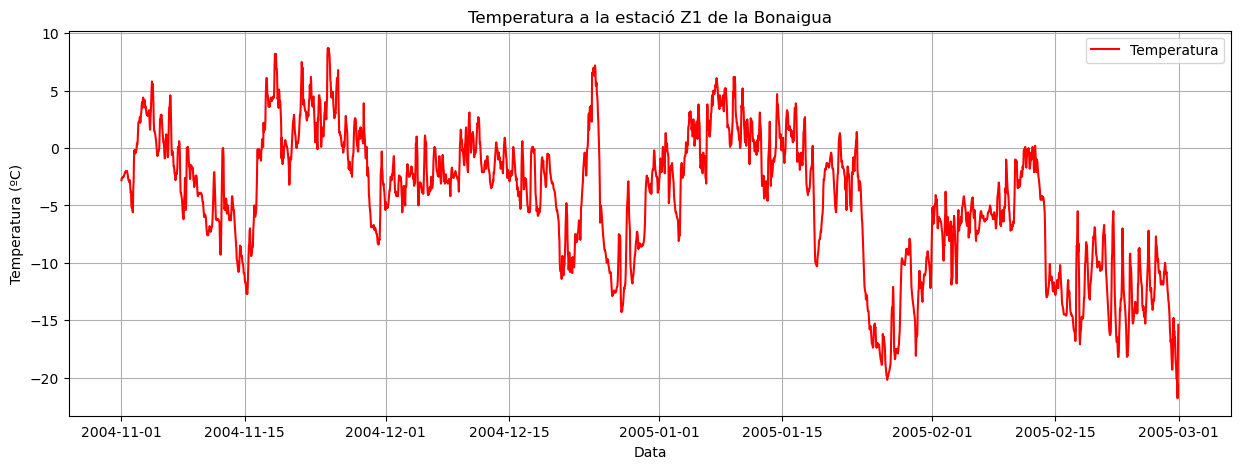

In [8]:
# Filtrar les dades per hivern 2009-2010 (novembre 2009 - febrer 2010)
any = 2005
any_ant = any - 1

df_hiverns_temporda = df_hiverns[
    ((df_hiverns['data'].dt.year == any_ant) & (df_hiverns['data'].dt.month >= 11)) | 
    ((df_hiverns['data'].dt.year == any) & (df_hiverns['data'].dt.month <= 2))
]

# Graficar la temperatura
plt.figure(figsize=(15, 5))
plt.plot(df_hiverns_temporda['data'], df_hiverns_temporda['valor'], label='Temperatura', color='red')
plt.title('Temperatura a la estació Z1 de la Bonaigua')
plt.xlabel('Data')
plt.ylabel('Temperatura (ºC)')
plt.legend()
plt.grid()
plt.show()


In [43]:
# Calcular las probabilitat de cada tipus de precipitació

prob_precipitacio = df_hiverns['precipitacio'].value_counts(normalize=True)

prob_precipitacio

precipitacio
N    0.716349
P    0.221608
A    0.062043
Name: proportion, dtype: float64

In [15]:
# Crear una columna per l'estat anterior de la precipitació
df_hiverns['precipitacio_anterior'] = df_hiverns['precipitacio'].shift(1)

# Eliminar les files amb NaN a la columna 'precipitacio_anterior' (ja que la primera fila no té valor anterior)
df_hiverns = df_hiverns.dropna(subset=['precipitacio_anterior'])

# Calcular les transicions: com passar d'un estat a un altre
transicions = pd.crosstab(df_hiverns['precipitacio_anterior'], df_hiverns['precipitacio'], normalize='index')



In [16]:
transicions

precipitacio,N,A,P
precipitacio_anterior,,,
N,0.979160,0.017712,0.003128
A,0.212982,0.592674,0.194344
P,0.007737,0.056785,0.935478


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


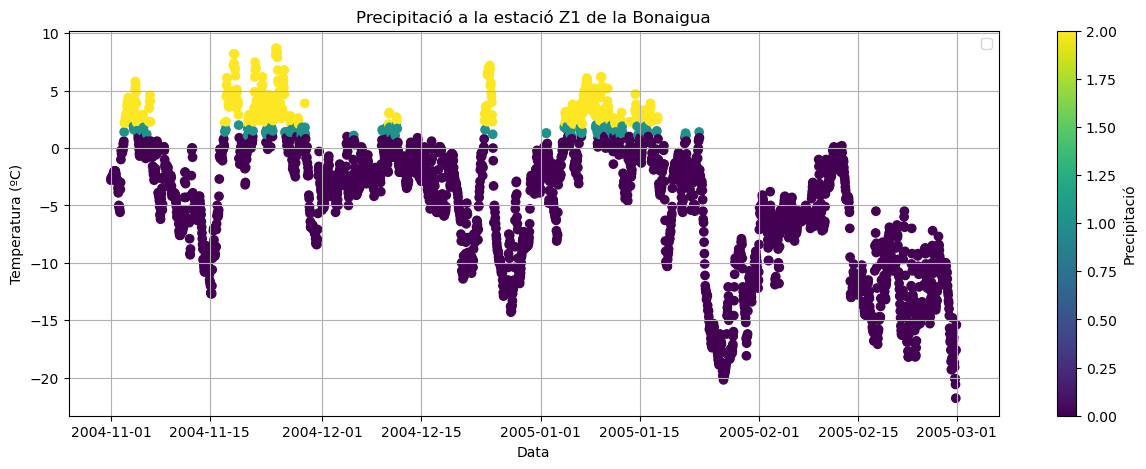

In [47]:
# Graficar les precipitacions en l'hivern 2009-2010

plt.figure(figsize=(15, 5))
# plt.plot(df_hiverns_temporda['data'], df_hiverns_temporda['valor'], label='Temperatura', color='red')

# Codificar la variable de precipitació per a la gràfica i representar-la

df_hiverns_temporda['precipitacio_codificada'] = df_hiverns_temporda['precipitacio'].map({'N': 0, 'A': 1, 'P': 2})

plt.scatter(df_hiverns_temporda['data'], df_hiverns_temporda['valor'], c=df_hiverns_temporda['precipitacio_codificada'], cmap='viridis')


plt.title('Precipitació a la estació Z1 de la Bonaigua')
plt.xlabel('Data')
plt.ylabel('Temperatura (ºC)')
plt.legend()
# Llegenda de colors de la codificació de la precipitació
plt.colorbar(label='Precipitació')

plt.grid()
plt.show()

In [40]:
# Simular el temps a partir de les probabilitats de transició en la mateuixa temporada

# Definir la durada de la simulació
dies_simul = len(df_hiverns_temporda)

# Definir la primera precipitació de la simulació
precipitacio_t0 = df_hiverns_temporda['precipitacio'].iloc[0]
precipitacio_t1 = df_hiverns_temporda['precipitacio'].iloc[1]

# Crear una llista per guardar les precipitacions simulades
precipitacions_simulades = [precipitacio_t0, precipitacio_t1]

# Simular la precipitació
for i in range(2, dies_simul):
    precipitacio_anterior = precipitacions_simulades[i - 1]
    probabilitats = transicions.loc[precipitacio_anterior]
    precipitacio_simulada = np.random.choice(probabilitats.index, p=probabilitats.values)
    precipitacions_simulades.append(precipitacio_simulada)

    # Afegir les precipitacions simulades al DataFrame
df_hiverns_temporda['precipitacio_simulada'] = precipitacions_simulades

# Codifica la precipitació simulada per a la gràfica
df_hiverns_temporda['precipitacio_simulada_codificada'] = df_hiverns_temporda['precipitacio_simulada'].map({'N': 0, 'A': 1, 'P': 2})

df_hiverns_temporda.head()

,data,valor,precipitacio,precipitacio_codificada,precipitacio_simulada,precipitacio_simulada_codificada
53856,2004-11-01 00:00:00+00:00,-2.8,N,0,N,0
53857,2004-11-01 01:00:00+00:00,-2.6,N,0,N,0
53858,2004-11-01 02:00:00+00:00,-2.6,N,0,N,0
53859,2004-11-01 03:00:00+00:00,-2.6,N,0,N,0
53860,2004-11-01 04:00:00+00:00,-2.5,N,0,N,0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


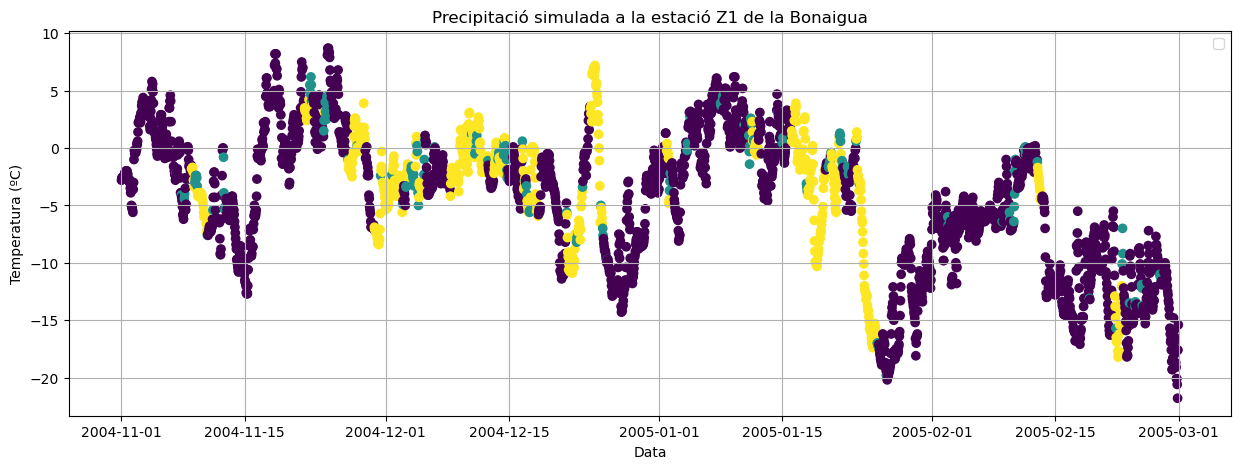

In [ ]:
# Graficar les precipitacions simulades en l'hivern 2009-2010 com grafic anterior

plt.figure(figsize=(15, 5))

plt.scatter(df_hiverns_temporda['data'], df_hiverns_temporda['valor'], c=df_hiverns_temporda['precipitacio_simulada_codificada'], cmap='viridis')

plt.title('Precipitació simulada a la estació Z1 de la Bonaigua')
plt.xlabel('Data')
plt.ylabel('Temperatura (ºC)')
plt.legend()
plt.grid()
plt.show()



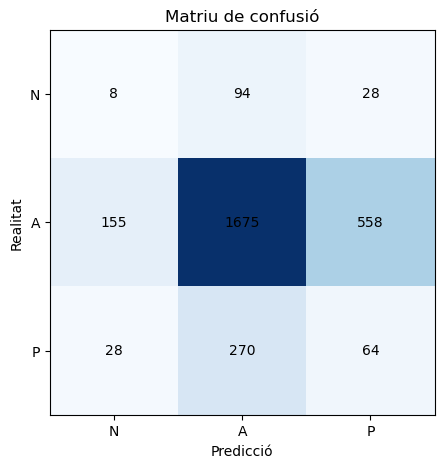

In [46]:
# Plot de la matriu de confusió

from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(df_hiverns_temporda['precipitacio'], df_hiverns_temporda['precipitacio_simulada'])

plt.figure(figsize=(5, 5))
plt.imshow(conf_matrix, cmap='Blues')

plt.xticks([0, 1, 2], ['N', 'A', 'P'])
plt.yticks([0, 1, 2], ['N', 'A', 'P'])

plt.xlabel('Predicció')
plt.ylabel('Realitat')

plt.title('Matriu de confusió')

for i in range(3):
    for j in range(3):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black')

plt.show()



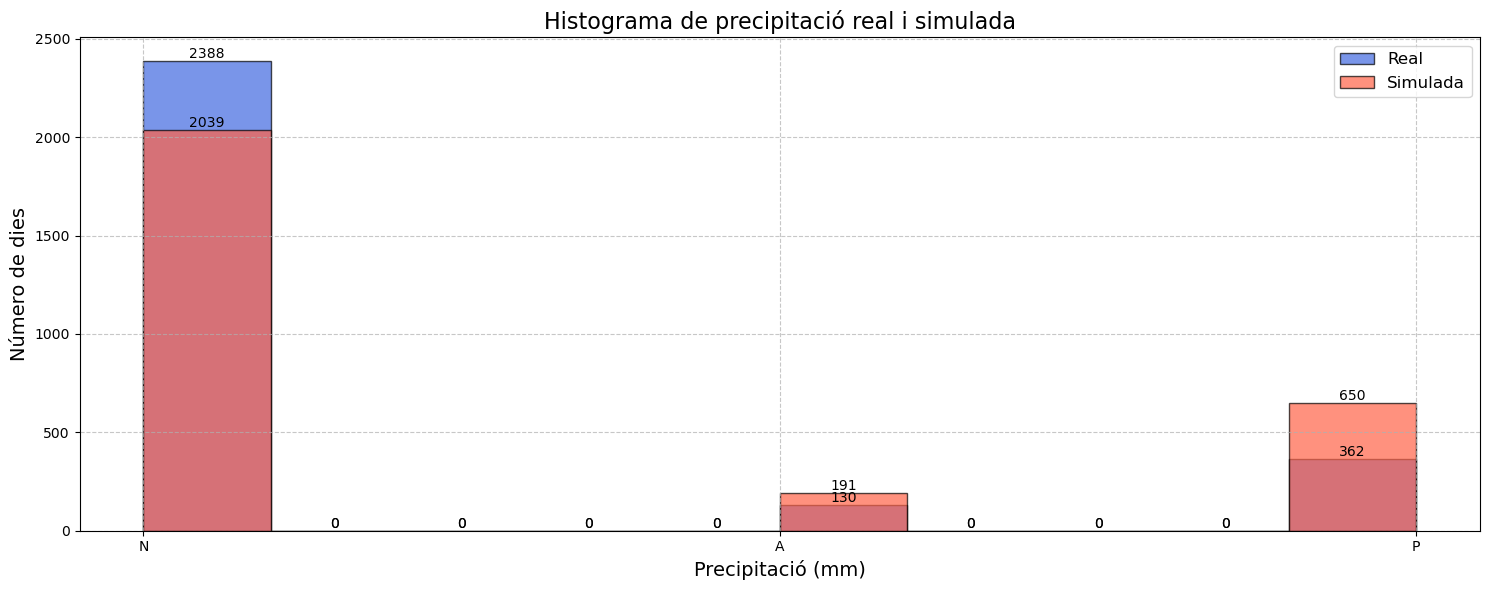

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Ajustar el tamaño de la figura
plt.figure(figsize=(15, 6))

# Histograma de datos reales
n_real, bins_real, patches_real = plt.hist(df_hiverns_temporda['precipitacio'], bins=10, alpha=0.7, label='Real', color='royalblue', edgecolor='black')

# Histograma de datos simulados
n_simulada, bins_simulada, patches_simulada = plt.hist(df_hiverns_temporda['precipitacio_simulada'], bins=10, alpha=0.7, label='Simulada', color='tomato', edgecolor='black')

# Añadir los números de las barras
for n, bins, patches in zip([n_real, n_simulada], [bins_real, bins_simulada], [patches_real, patches_simulada]):
    for i in range(len(patches)):
        height = patches[i].get_height()
        x_position = patches[i].get_x() + patches[i].get_width() / 2
        y_position = height
        plt.text(x_position, y_position, str(int(height)), ha='center', va='bottom', fontsize=10)

# Título y etiquetas
plt.title('Histograma de precipitació real i simulada', fontsize=16)
plt.xlabel('Precipitació (mm)', fontsize=14)
plt.ylabel('Número de dies', fontsize=14)

# Leyenda y estilo
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()  # Ajuste para que no se corte el gráfico

# Mostrar el gráfico
plt.show()
# Histograma dels dies de cada tipus de precipitació reals i simulades amb el numeroplt.figure(figsize=(15, 5))plt.hist(df_hiverns_temporda['precipitacio'], bins=3, alpha=0.5, label='Real', color='blue')plt.hist(df_hiverns_temporda['precipitacio_simulada'], bins=3, alpha=0.5, label='Simulada', color='red')plt.title('Histograma de precipitació real i simulada')plt.xlabel('Precipitació')plt.ylabel('Dies')plt.legend()plt.grid()plt.show()